In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


def plot_segmentation_slice(img, label, k=0):
    img = np.asarray(img)
    label = np.asarray(label)
    if img.ndim != 4 or label.ndim != 4:
        raise ValueError("img must be (C, Z, Y, X) and label must be (1, Z, Y, X).")
    if label.shape[0] != 1 or img.shape[1:] != label.shape[1:]:
        raise ValueError("Shape mismatch between img and label.")
    if not label.any():
        raise RuntimeError("No labeled voxels found.")

    z = int(k % img.shape[1])

    seg = label[0]
    channel_slices = img[:, z]
    seg_slice = seg[z]

    n_channels = channel_slices.shape[0]
    fig, axes = plt.subplots(2, n_channels + 1, figsize=(4 * (n_channels + 1), 8))
    if n_channels == 1:
        axes = axes.reshape(2, n_channels + 1)

    for ch in range(n_channels):
        axes[0, ch].imshow(channel_slices[ch], cmap="gray")
        axes[0, ch].set_title(f"channel {ch}")
        axes[0, ch].axis("off")
        im = axes[1, ch].imshow(channel_slices[ch], cmap="inferno")
        axes[1, ch].axis("off")
        fig.colorbar(im, ax=axes[1, ch], fraction=0.046, pad=0.04)

    axes[0, -1].imshow(seg_slice, cmap=ListedColormap(["black", "white"]), vmin=0, vmax=1, interpolation="nearest")
    axes[0, -1].set_title("segmentation")
    axes[0, -1].axis("off")
    axes[1, -1].axis("off")

    plt.tight_layout()
    return fig, axes, z


def plot_three_label_slices(label1, label2, label3, k=0, flip=None):
    if flip is not None:
        label1 = np.flip(label1, flip)
        label2 = np.flip(label2, flip)
        label3 = np.flip(label3, flip)

    labels = [np.asarray(lb) for lb in (label1, label2, label3)]
    for i, lb in enumerate(labels):
        if lb.ndim not in (3, 4):
            raise ValueError(f"label{i + 1} must be (Z, Y, X) or (1, Z, Y, X).")
        if lb.ndim == 4:
            if lb.shape[0] != 1:
                raise ValueError(f"label{i + 1} has unexpected channel dimension.")
            labels[i] = lb[0]
        if not labels[i].any():
            raise RuntimeError(f"label{i + 1} has no labeled voxels.")

    z = int(k % min(lb.shape[0] for lb in labels))
    slices = [lb[z] for lb in labels]

    h = min(s.shape[0] for s in slices)
    w = min(s.shape[1] for s in slices)
    slices = [s[:h, :w] for s in slices]

    titles = ["yucca", "nnunet", "asparagus"]

    cmap = ListedColormap(["black", "white"])
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, slc, idx in zip(axes, slices, range(3)):
        ax.imshow(slc, cmap=cmap, vmin=0, vmax=1, interpolation="nearest")
        ax.set_title(titles[idx])
        ax.axis("off")

    plt.tight_layout()
    return fig, axes, z


def znorm(x: np.ndarray, channel_axis: int = 0, eps: float = 1e-8, inplace: bool = False) -> np.ndarray:
    axes = tuple(i for i in range(x.ndim) if i != channel_axis)
    mu = x.mean(axis=axes, keepdims=True)
    sigma = x.std(axis=axes, keepdims=True)
    if inplace:
        x -= mu
        x /= sigma + eps
        return x
    return (x - mu) / (sigma + eps)

In [ ]:
import blosc2
import numpy as np
import torch

case = "0171"

ttunet_path = "/dtu/p1/asbmun/data/ttunet/preprocessed/Dataset601_ISLES22/Spacing__1.00_1.00_1.00___Norm__Z_Z/"
asp_path = f"/dtu/p1/asbmun/data/asparagus/data/Task601_SEG_ISLES22_ADCDWI/ISLES22/ISLES-2022/images/\
    sub-strokecase{case}/ses-0001/anat/"
asp2_path = f"/dtu/p1/asbmun/data/asparagus/data/Task601_SEG_ISLES22_experimental/ISLES22/ISLES-2022/\
    images/sub-strokecase{case}/ses-0001/anat/"
vol = f"sub-strokecase{case}_ses-0001"

In [53]:
b2_data = blosc2.open(ttunet_path + vol + ".b2nd")
b2_label = blosc2.open(ttunet_path + vol + "_seg.b2nd")

ttunet_x = np.asarray(b2_data)
ttunet_y = np.asarray(b2_label)

In [54]:
asp_data = torch.load(asp_path + vol + ".pt").permute(0, 3, 2, 1).flip(3).numpy()

asp_x = znorm(asp_data[:-1])
asp_y = asp_data[-1:]

In [55]:
asp2_data = torch.load(asp2_path + vol + ".pt").permute(0, 3, 2, 1).flip(3).numpy()

asp2_x = znorm(asp2_data[:-1])
asp2_y = asp2_data[-1:]

In [56]:
print("Asparagus:", asp_x.shape, asp_y.shape)
print("Asparagus2:", asp2_x.shape, asp2_y.shape)
print("ttunet:", ttunet_x.shape, ttunet_y.shape)


print("max", asp_x.max(), ttunet_x.max())
print("min", asp_x.min(), ttunet_x.min())

Asparagus: (2, 132, 164, 142) (1, 132, 164, 142)
Asparagus2: (2, 132, 164, 142) (1, 132, 164, 142)
ttunet: (2, 130, 162, 140) (1, 130, 162, 140)
max 16.411015 20.859259
min -2.5365782 -3.4484997


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'yucca'}>,
        <Axes: title={'center': 'nnunet'}>,
        <Axes: title={'center': 'asparagus'}>], dtype=object),
 105)

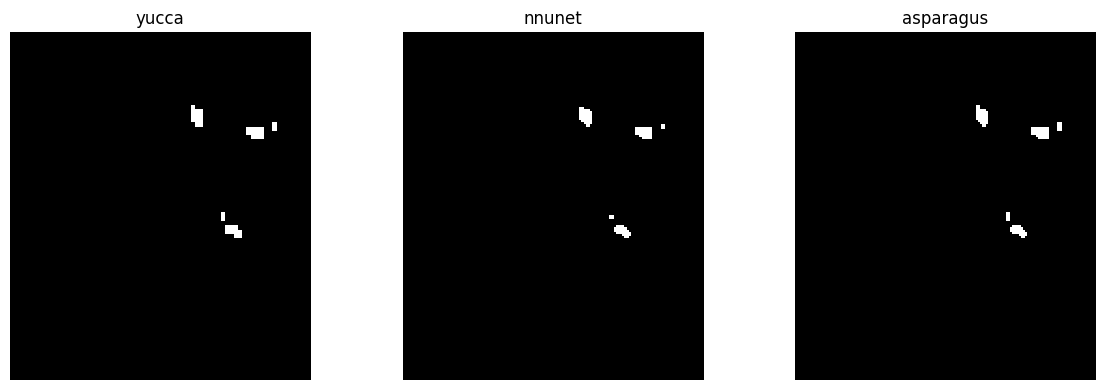

In [88]:
plot_three_label_slices(asp_y, ttunet_y, asp2_y, k=105, flip=None)

(<Figure size 1200x800 with 8 Axes>,
 array([[<Axes: title={'center': 'channel 0'}>,
         <Axes: title={'center': 'channel 1'}>,
         <Axes: title={'center': 'segmentation'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object),
 82)

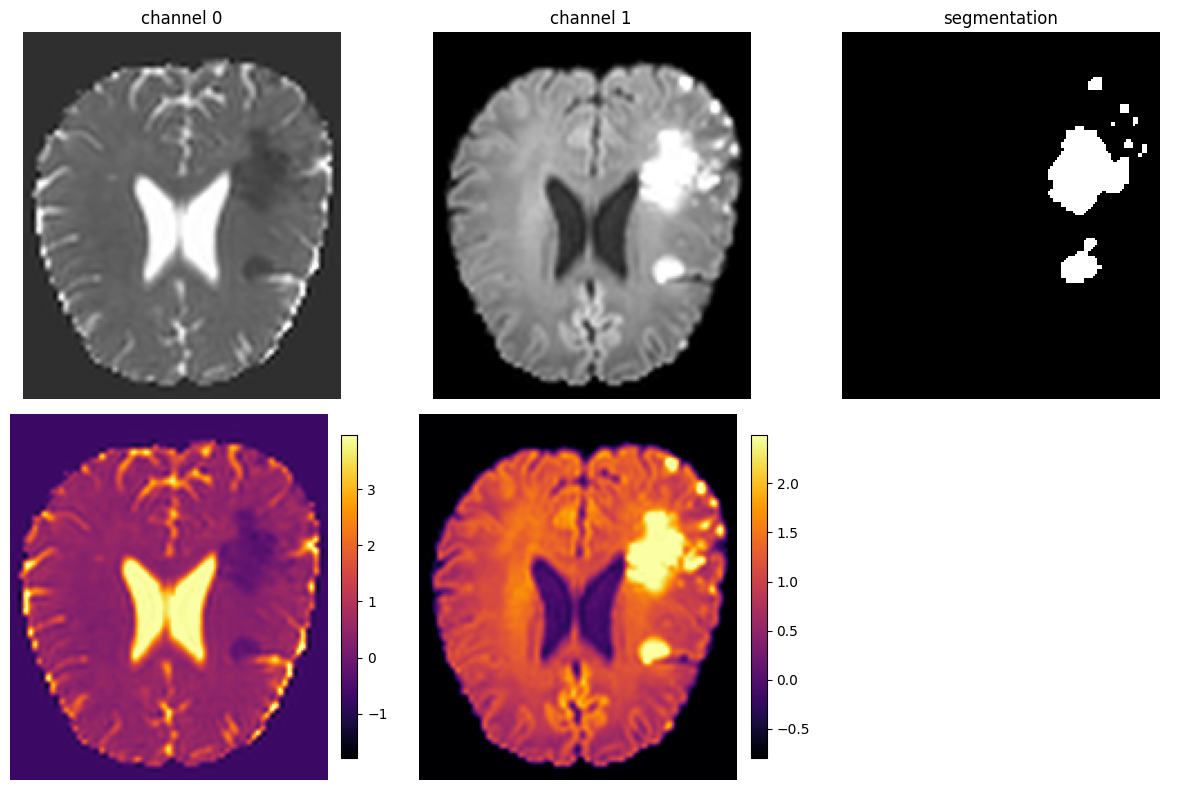

In [30]:
plot_segmentation_slice(asp_x, asp_y, k=82)

(<Figure size 1200x800 with 8 Axes>,
 array([[<Axes: title={'center': 'channel 0'}>,
         <Axes: title={'center': 'channel 1'}>,
         <Axes: title={'center': 'segmentation'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object),
 82)

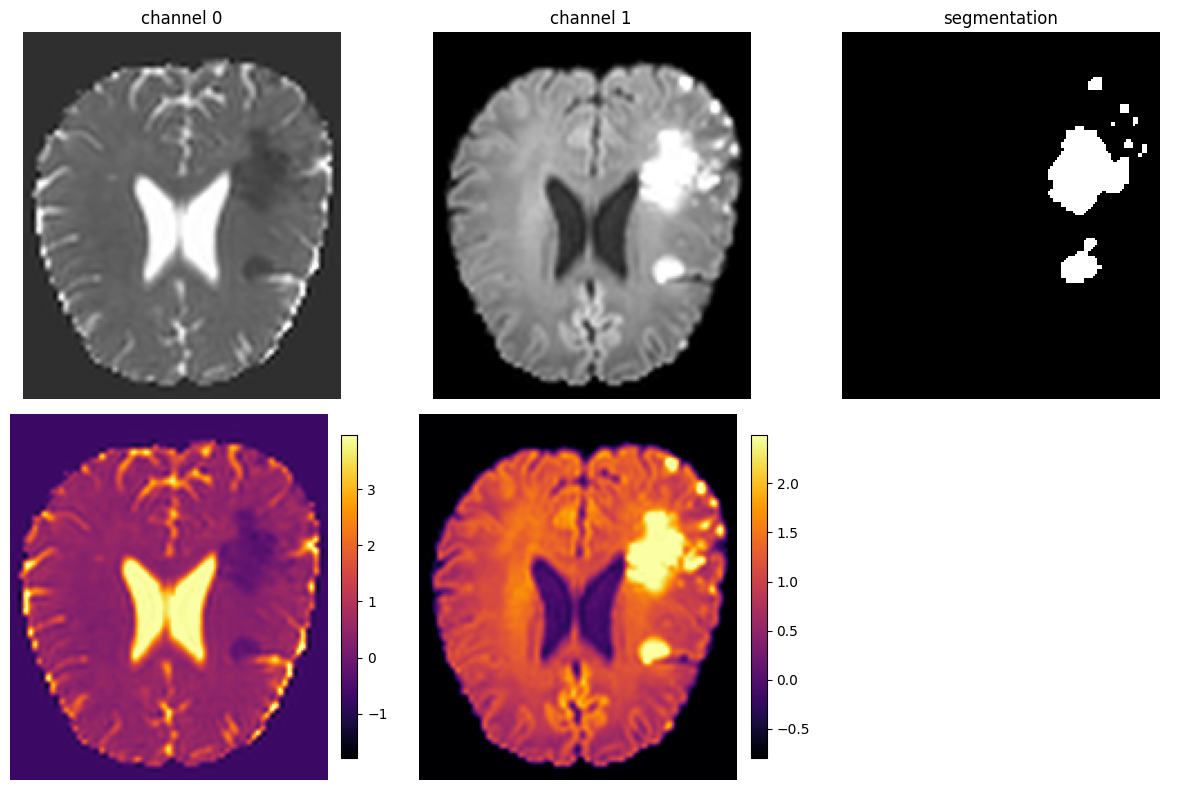

In [33]:
plot_segmentation_slice(asp2_x, asp2_y, k=82)

(<Figure size 1200x800 with 8 Axes>,
 array([[<Axes: title={'center': 'channel 0'}>,
         <Axes: title={'center': 'channel 1'}>,
         <Axes: title={'center': 'segmentation'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object),
 82)

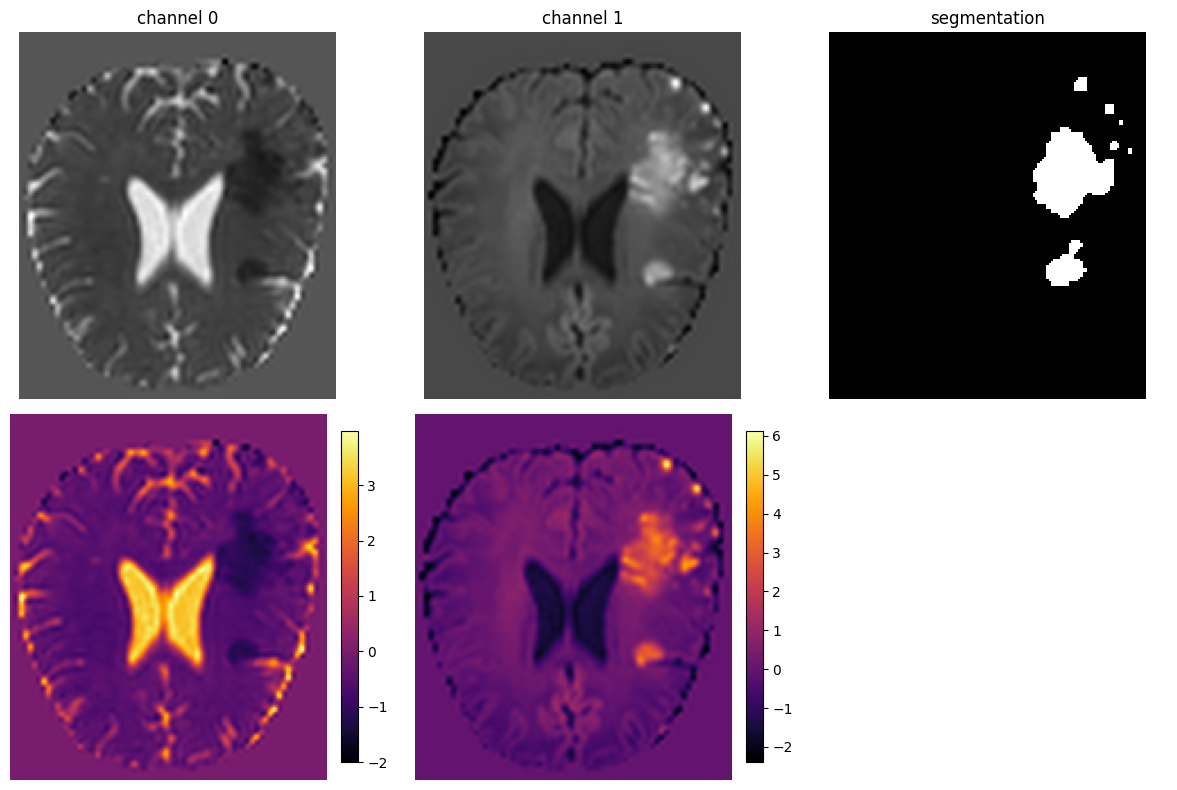

In [34]:
plot_segmentation_slice(ttunet_x, ttunet_y, k=82)

In [118]:
ttunet_x[1, 0, 0, 0]

np.float32(-6.304644e-21)